# Model benchmarks

## Imports

In [26]:
import pandas as pd
import numpy as np
from os import path
import pickle
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, precision_score, recall_score, classification_report,\
    make_scorer, precision_recall_curve, auc
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, train_test_split

from sbdetection.models import baseline
from sbdetection.utils import NltkCorpusReader
from sbdetection.preprocessing.preprocessor import feature_extraction, \
    sentences_to_binary_target, binary_target_to_sentences
from sbdetection.models.MLBased import get_estimator

## Import data from nltk corpus : treebank, brown,  inaugural

### Train data

In [4]:
treebank_sample = NltkCorpusReader(corpus_name='treebank', from_sentence=0, to_sentence=3000)
treebank_text = treebank_sample.corpus_full_text

Corpus: treebank: len - 3000 / avg sent len - 135


In [5]:
brown_sample = NltkCorpusReader(corpus_name='brown', from_sentence=0, to_sentence=3000, extra_args={'categories': ['romance']})
brown_text = brown_sample.corpus_full_text

Corpus: brown: len - 3000 / avg sent len - 73


In [6]:
gutenberg_sample = NltkCorpusReader(corpus_name='gutenberg', from_sentence=4, to_sentence=30_000) # ignore headline
gutenberg_text = gutenberg_sample.corpus_full_text

Corpus: gutenberg: len - 29996 / avg sent len - 136


## Preprocessing
Tokenize (with a defined tokenizer) and generate a set with one token per row and a target binary column: whether a token is the end of a sentence.

In [7]:
# nltk corpus sets
df_feature_brown = sentences_to_binary_target(brown_sample.sentence_sample)
df_feature_treebank = sentences_to_binary_target(treebank_sample.sentence_sample)
df_feature_gutenberg = sentences_to_binary_target(gutenberg_sample.sentence_sample)

In [8]:
# test gutenberg
test_sentences_reverse = binary_target_to_sentences(df_feature_gutenberg)
assert len(gutenberg_sample.sentence_sample) == len(test_sentences_reverse)

In [9]:
# test treebank
test_sentences_reverse = binary_target_to_sentences(df_feature_treebank)
assert len(treebank_sample.sentence_sample) == len(test_sentences_reverse)

In [10]:
# test brown
test_sentences_reverse = binary_target_to_sentences(df_feature_brown)
assert len(brown_sample.sentence_sample) == len(test_sentences_reverse)

#### Datasets descriptive statistic
Class repartition: 

class 0: non ending token

class 1: ending token

In [11]:
# descriptive analysis utils
cnd_full_stop = lambda x:('.' in x)|('?' in x)|('!' in x)
mask_full_stop = lambda y:y['token'].apply(cnd_full_stop)==1
def part_full_stop_end(df):
    """Part of tokens containing a full stops that is a punctuation end"""
    return round(df.loc[mask_full_stop(df), 'target'].mean(), 2)

def token_class_repartition(df):
    return np.round(df['target'].value_counts()/len(df), 3).values

In [14]:
sample_set = {
'Treebank':{"text":treebank_text,"target":df_feature_treebank},
'Gutenberg':{"text":gutenberg_text,"target":df_feature_gutenberg},
'Brown':{"text":brown_text, "target":df_feature_brown},
}

In [13]:
# print statistics
for corpus, dataset in sample_set.items():
    print(f'{corpus} sample set')
    print(f'Class reparation \n[0 1]\n{token_class_repartition(dataset["target"])}')
    print(f'Part of tokens containing a full stops that is a punctuation end: {part_full_stop_end(dataset["target"])}')
    print('----------------------------------------------')

Treebank sample set
Class reparation 
[0 1]
[0.956 0.044]
Part of tokens containing a full stops that is a punctuation end: 0.65
----------------------------------------------
Gutenberg sample set
Class reparation 
[0 1]
[0.961 0.039]
Part of tokens containing a full stops that is a punctuation end: 0.88
----------------------------------------------
Brown sample set
Class reparation 
[0 1]
[0.925 0.075]
Part of tokens containing a full stops that is a punctuation end: 0.98
----------------------------------------------


The repartition of tokens in class 1 and class 0 is very imbalanced in all dataset and around 95%-5%.\
The part of tokens containing a full stops that is an actual sentence end varies more and goes from 0.64 to 0.94.

## Baseline performances on test

#### Application

In [14]:
%%time
baseline_predictions = {}
# get target prediction form sentences in the test set using the rule based baseline detection
for corpus, dataset in sample_set.items():
    text = dataset["text"]
    baseline_predictions[corpus] = sentences_to_binary_target(baseline.predict_sentences(text))

CPU times: user 2min 5s, sys: 12.9 s, total: 2min 18s
Wall time: 2min 20s


#### Evaluation

In [15]:
# print a classification report for the test set using scikit-learn
for corpus, dataset in sample_set.items():
    y_true = dataset["target"]["target"]
    y_pred = baseline_predictions[corpus]["target"]
    print(f'{corpus} sample set')
    print(f'f1 score: {round(f1_score(y_true, y_pred), 2)}')
    print(f'precision: {round(precision_score(y_true, y_pred), 2)}')
    print(f'recall: {round(recall_score(y_true, y_pred), 2)}')
    print('----------------------------------------------')

Treebank sample set
f1 score: 0.84
precision: 0.97
recall: 0.73
----------------------------------------------
Gutenberg sample set
f1 score: 0.84
precision: 1.0
recall: 0.72
----------------------------------------------
Brown sample set
f1 score: 0.89
precision: 1.0
recall: 0.8
----------------------------------------------


## Trained model part

### Feature extraction
frequency of the word
 in the text

In [15]:
shifts = {"current": 0, "next": -1}
for corpus, dataset in sample_set.items():
    # feature extraction
    _data = feature_extraction(dataset['target'], shifts)
    assert _data.isnull().sum().sum() == 0
    # split data into features (X) and target (y)
    dataset['data_feature'] = _data
    dataset['X_feature'] = _data.drop(['token', 'target'], axis=1)
    dataset['y_feature'] = _data['target']

## Estimator comparison and hyperparameter opti

In [29]:
# utils plot precision recall curve
def plot_precision_recall_curve(_X_test, _y_test, model):
    """
    Plot precision recall curve for the class 1
    """
    # probabilities prediction
    lr_probs = model.predict_proba(_X_test)
    # keep probabilities for the positive outcome only (minority class)
    lr_probs = lr_probs[:, 1]
    lr_precision, lr_recall, _ = precision_recall_curve(_y_test, lr_probs)

    # scoring
    lr_auc = auc(lr_recall, lr_precision)
    print('RF: auc=%.3f' % (lr_auc))
    
    plt.plot(lr_recall, lr_precision, marker='.', label='trained_model')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

In [21]:
# split the Gutenberg set in train, text
X = sample_set['Gutenberg']['data_feature'].drop(['target', 'token'], axis=1)
y = sample_set['Gutenberg']['data_feature']['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#### Logistic Regression Hyperparameter optimization

In [23]:
# estimator definition
LR_clf = get_estimator('LR', parameters=None)

# parameter grid for grid search
parameters = {'penalty':['none', 'l2'],
              'C':[1, 0.1, 0.01],
              'class_weight':[None, 'balanced'],
              'max_iter':[1000]
              }

# HalvingGridSearch
LR_gridsearch = HalvingGridSearchCV(
    LR_clf,
    parameters,
    scoring = make_scorer(f1_score)
)

LR_gridsearch.fit(X_train, y_train)
print(LR_gridsearch.best_score_)
print(LR_gridsearch.best_estimator_)

0.9652015857685153
LogisticRegression(C=1, max_iter=1000, random_state=1)


RF: auc=0.989


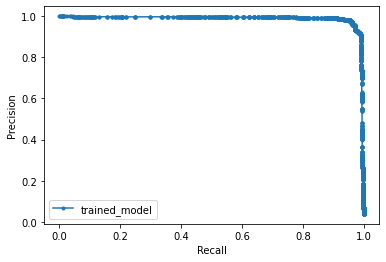

In [42]:
plot_precision_recall_curve(X_test, y_test, LR_gridsearch.best_estimator_)

#### RandomForestClassifier Hyperparameter optimization

In [24]:
# estimator definition
RFC_clf = get_estimator('RFC', parameters=None)

# parameter grid for grid search
parameters = {'n_estimators':[50, 100],
              'criterion':['gini', 'entropy'],
              'max_depth':[3, 5, 10],
              'class_weight':[None, 'balanced']
              }

# HalvingGridSearch
RFC_gridsearch = HalvingGridSearchCV(
    RFC_clf,
    parameters,
    scoring = make_scorer(f1_score)
)

RFC_gridsearch.fit(X_train, y_train)
print(RFC_gridsearch.best_score_)
print(RFC_gridsearch.best_estimator_)

0.9894303802396524
RandomForestClassifier(max_depth=10, random_state=1)


#### precision recall curve

RF: auc=0.998


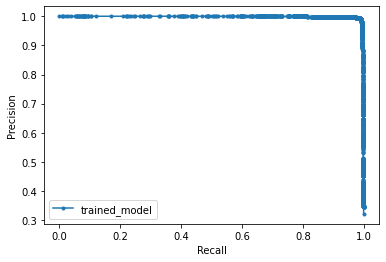

In [30]:
plot_precision_recall_curve(X_test, y_test, RFC_gridsearch.best_estimator_)

#### XGBoost Hyperparameter optimization

In [44]:
# estimator definition
XGB_clf = get_estimator('XGB', parameters=None)

# parameter grid for grid search
parameters = {'n_estimators':[50, 100],
              'max_depth':[3, 5, 10],
              }

# HalvingGridSearch
XGB_gridsearch = HalvingGridSearchCV(
    XGB_clf,
    parameters,
    scoring = make_scorer(f1_score)
)

XGB_gridsearch.fit(X_train, y_train)
print(XGB_gridsearch.best_score_)
print(XGB_gridsearch.best_estimator_)

0.9891683772645934
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


/usr/local/anaconda3/envs/py38_sbd/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


RF: auc=0.998


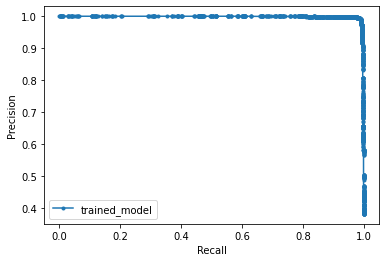

In [46]:
plot_precision_recall_curve(X_test, y_test, XGB_gridsearch.best_estimator_)

### Test on test sets

In [55]:
# refit the RFC gridsearch best estimators on the total X_train
model_train = RFC_gridsearch.best_estimator_
model_train.fit(X, y)

RandomForestClassifier(max_depth=10, random_state=1)

In [56]:
for corpus in ['Brown', 'Treebank']:
    _X_test = sample_set[corpus]['X_feature']
    _y_test = sample_set[corpus]['y_feature']
    print(f'{corpus} sample set')
    print(classification_report(model_train.predict(_X_test), _y_test))
    print('----------------------------------------------')

Brown sample set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37251
           1       0.94      1.00      0.97      2833

    accuracy                           1.00     40084
   macro avg       0.97      1.00      0.98     40084
weighted avg       1.00      1.00      1.00     40084

----------------------------------------------
Treebank sample set
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     65236
           1       0.96      0.88      0.92      3271

    accuracy                           0.99     68507
   macro avg       0.98      0.94      0.96     68507
weighted avg       0.99      0.99      0.99     68507

----------------------------------------------


## Serialize model as pkl

#### Serialize

In [24]:
model_train = RFC_gridsearch.best_estimator_
pickle.dump(model_train, open('model_rfc_gs.pkl', 'wb'))